# **Number Detection**

# All Modes

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Load Digits dataset
digits = datasets.load_digits()

# Flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

df_data = pd.DataFrame(data)
df_data = df_data.astype('float32')

# Split the dataset into training and testing sets for all states
X_train, X_test, y_train, y_test = train_test_split(df_data, digits.target, test_size=0.2, shuffle=False)

# Function to calculate moments for images
def calculate_moments(images):
    moments_list = []
    for image in images:
        img = np.array(image, dtype=np.uint8).reshape(8, 8)
        m = cv2.moments(img)
        moments_list.append([m['m00'], m['m10'], m['m01'], m['m20'], m['m11'], m['m02'], m['m30'], m['m21'], m['m12'], m['m03']])
    return np.array(moments_list)

# Calculate moments for all states
moments_normal = calculate_moments(X_test.values)
moments_flipped = calculate_moments(np.array([np.fliplr(img.reshape(8, 8)) for img in X_test.values]))
moments_translated = calculate_moments(np.array([cv2.warpAffine(img.reshape(8, 8), np.float32([[1, 0, 2], [0, 1, 0]]), (8, 8)) for img in X_test.values]))
moments_rotated = calculate_moments(np.array([cv2.rotate(img.reshape(8, 8), cv2.ROTATE_90_CLOCKWISE) for img in X_test.values]))

# Define and compile models for each state
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

model_normal = create_model((10, 1))
model_flipped = create_model((10,))
model_translated = create_model((10,))
model_rotated = create_model((10,))

# Train models for each state
model_normal.fit(moments_normal, y_test, epochs = 100, steps_per_epoch = 45)
model_flipped.fit(moments_flipped, y_test, epochs = 100, steps_per_epoch = 45)
model_translated.fit(moments_translated, y_test, epochs = 100, steps_per_epoch = 45)
model_rotated.fit(moments_rotated, y_test, epochs = 100, steps_per_epoch = 45)

# Evaluate models and print test accuracies
test_loss_normal, test_acc_normal = model_normal.evaluate(moments_normal, y_test, verbose=2)
test_loss_flipped, test_acc_flipped = model_flipped.evaluate(moments_flipped, y_test, verbose=2)
test_loss_translated, test_acc_translated = model_translated.evaluate(moments_translated, y_test, verbose=2)
test_loss_rotated, test_acc_rotated = model_rotated.evaluate(moments_rotated, y_test, verbose=2)

print('\nTest accuracy with normal images:', test_acc_normal)
print('Test accuracy with flipped images:', test_acc_flipped)
print('Test accuracy with translated images:', test_acc_translated)
print('Test accuracy with rotated images:', test_acc_rotated)

# Create confusion matrices for each state
models = {
    'Normal': model_normal,
    'Flipped': model_flipped,
    'Translated': model_translated,
    'Rotated': model_rotated
}

for state, model in models.items():
    y_pred = np.argmax(model.predict(locals()[f'moments_{state.lower()}']), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Calculate precision, recall, and F1-score
    report = classification_report(y_test, y_pred, zero_division = 1, target_names=[str(i) for i in range(10)], output_dict=True)
    print('#################################################################################')
    print('#################################################################################')
    print('#################################################################################')
    print('#################################################################################')

    # Print classification report
    print(f"\nClassification Report for {state} Images (Without Moments):")
    print(classification_report(y_test, y_pred, zero_division = 1, target_names=[str(i) for i in range(10)]))

    print('#################################################################################')
    print('#################################################################################')
    print('#################################################################################')
    print('#################################################################################')
    print('#################################################################################')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {state} Images')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Epoch 1/100


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_122" is incompatible with the layer: expected shape=(None, 360, 96), found shape=(8, 312)


# Extract Features

In [ ]:
# Function to calculate moments for images
def calculate_moments(images):
    moments_list = []
    contour_areas = []
    perimeters = []
    approximated_contours = []
    convex_hulls = []
    straight_bounding_rectangles = []
    rotated_bounding_rectangles = []
    minimum_enclosing_circles = []
    fitted_ellipses = []
    fitted_lines = []

    for image in images:
        img = np.array(image, dtype=np.uint8).reshape(8, 8)
        m = cv2.moments(img)

        # Calculate contour area
        contour_area = m['m00']
        contour_areas.append(contour_area)

        # Calculate perimeter using contour
        contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 3:  # For OpenCV older versions
            _, contours, _ = contours
        contour = contours[0]  # Assuming there's only one contour per image

        # Calculate perimeter using contour
        perimeter = cv2.arcLength(contour[0], True)
        perimeters.append(perimeter)

        # Approximate contour using cv2.approxPolyDP()
        epsilon = 0.1 * perimeter
        approximated_contour = cv2.approxPolyDP(contour[0], epsilon, True)
        approximated_contours.append(approximated_contour)

        # Find convex hull of a contour
        convex_hull = cv2.convexHull(contour[0])
        convex_hulls.append(convex_hull)

        # Find straight bounding rectangle
        x, y, w, h = cv2.boundingRect(contour[0])
        straight_bounding_rectangles.append((x, y, w, h))

        # Find rotated bounding rectangle
        rotated_rect = cv2.minAreaRect(contour[0])
        box = cv2.boxPoints(rotated_rect)
        box = np.int0(box)
        rotated_bounding_rectangles.append(box)

        # Find minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(contour[0])
        center = (int(x), int(y))
        radius = int(radius)
        minimum_enclosing_circles.append((center, radius))

        # Fit an ellipse to a contour (if it has at least 5 points)
        if len(contour) >= 5:
            ellipse = cv2.fitEllipse(contour)
            fitted_ellipses.append(ellipse)
        else:
            fitted_ellipses.append(None)

        # Fit a line to a set of points
        rows, cols = img.shape[:2]
        [vx, vy, x, y] = cv2.fitLine(contour[0], cv2.DIST_L2, 0, 0.01, 0.01)
        lefty = int((-x * vy / vx) + y)
        righty = int(((cols - x) * vy / vx) + y)
        fitted_lines.append(((cols - 1, righty), (0, lefty)))

        moments_list.append([m['m00'], m['m10'], m['m01'], m['m20'], m['m11'], m['m02'], m['m30'], m['m21'], m['m12'], m['m03']])

    # Convert lists to numpy arrays for further processing
    moments_array = np.array(moments_list)
    contour_areas = np.array(contour_areas)
    perimeters = np.array(perimeters)

    return moments_array, contour_areas, perimeters, approximated_contours, convex_hulls, straight_bounding_rectangles, \
           rotated_bounding_rectangles, minimum_enclosing_circles, fitted_ellipses, fitted_lines

# Calculate moments and extract features for all images
moments_array, contour_areas, perimeters, approximated_contours, convex_hulls, straight_bounding_rectangles, \
rotated_bounding_rectangles, minimum_enclosing_circles, fitted_ellipses, fitted_lines = calculate_moments(pd.DataFrame(digits.data).values)

<ipython-input-2-a7693e15036e>:48: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
<ipython-input-2-a7693e15036e>:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lefty = int((-x * vy / vx) + y)
<ipython-input-2-a7693e15036e>:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  righty = int(((cols - x) * vy / vx) + y)


# Print and Plot Contour Areas

Digit 0: Contour Area = 294.0
Digit 1: Contour Area = 313.0
Digit 2: Contour Area = 344.0
Digit 3: Contour Area = 267.0
Digit 4: Contour Area = 258.0
Digit 5: Contour Area = 342.0
Digit 6: Contour Area = 306.0
Digit 7: Contour Area = 290.0
Digit 8: Contour Area = 357.0
Digit 9: Contour Area = 329.0


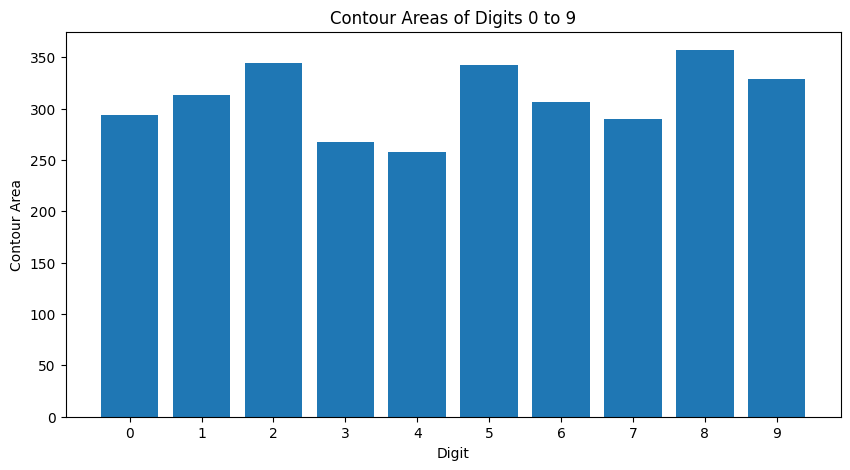

In [ ]:
# Print contour areas for digits 0 to 9
for i in range(10):
    area = contour_areas[i]
    print(f"Digit {i}: Contour Area = {area}")

# Extract contour areas for digits 0 to 9
digits_contour_areas = contour_areas[:10]

# Plot contour areas for digits 0 to 9
plt.figure(figsize=(10, 5))
plt.bar(range(10), digits_contour_areas)
plt.xlabel('Digit')
plt.ylabel('Contour Area')
plt.title('Contour Areas of Digits 0 to 9')
plt.xticks(range(10), range(10))
plt.show()

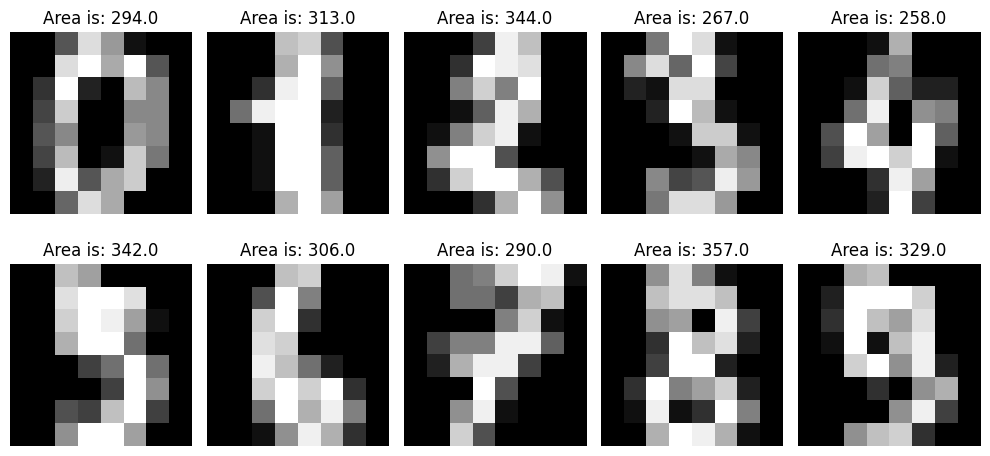

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(10):
    img = np.array(digits.images[i], dtype=np.uint8)
    m = cv2.moments(img)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Area is: {m['m00']}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print and Plot Perimeters

Digit 0: Perimeter = 21.071067690849304
Digit 1: Perimeter = 19.656854152679443
Digit 2: Perimeter = 23.071067690849304
Digit 3: Perimeter = 24.727921724319458
Digit 4: Perimeter = 21.071067690849304
Digit 5: Perimeter = 23.313708305358887
Digit 6: Perimeter = 21.656854152679443
Digit 7: Perimeter = 27.313708305358887
Digit 8: Perimeter = 23.071067690849304
Digit 9: Perimeter = 23.313708186149597


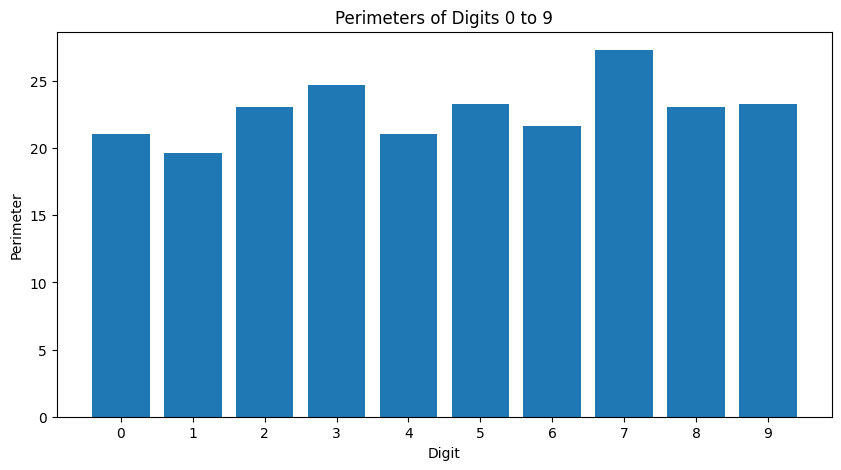

In [ ]:
# Print perimeters for digits 0 to 9
for i in range(10):
    perimeter = perimeters[i]
    print(f"Digit {i}: Perimeter = {perimeter}")

# Extract perimeters for digits 0 to 9
digits_perimeters = perimeters[:10]

# Plot perimeters for digits 0 to 9
plt.figure(figsize=(10, 5))
plt.bar(range(10), digits_perimeters)
plt.xlabel('Digit')
plt.ylabel('Perimeter')
plt.title('Perimeters of Digits 0 to 9')
plt.xticks(range(10), range(10))
plt.show()

# Plot Bounding Rectangles

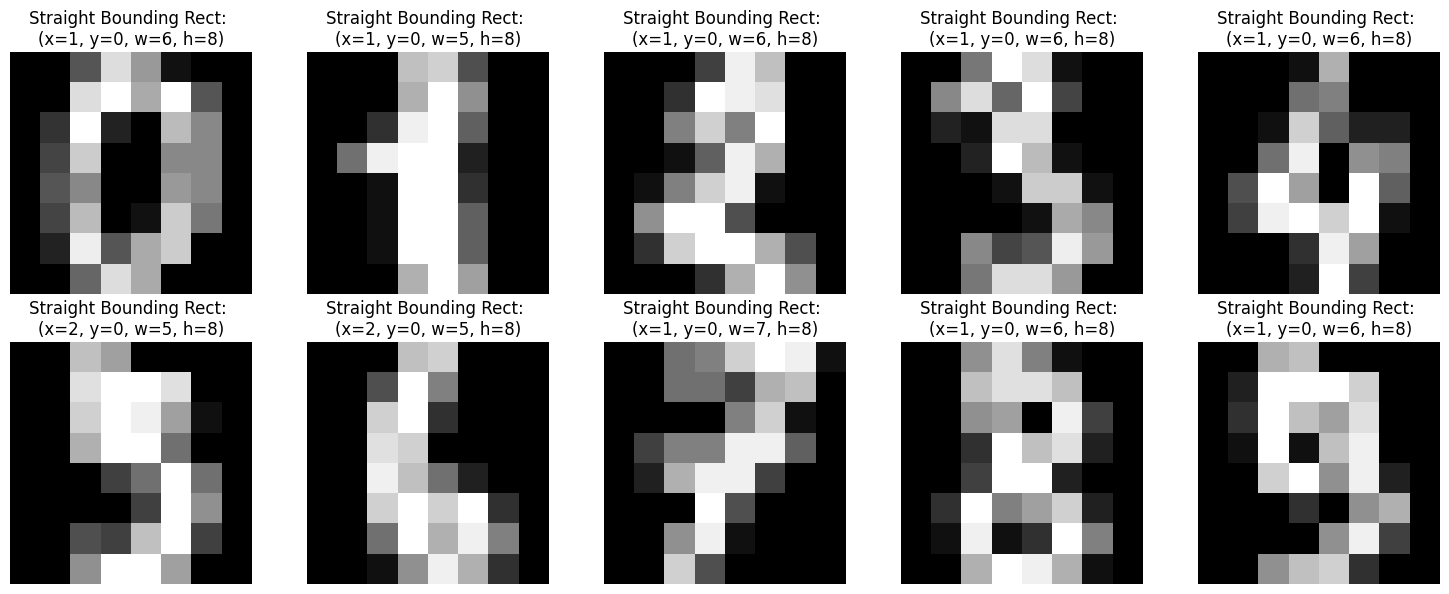

In [ ]:
def plot_images_with_bounding_rectangles(images, bounding_rectangles_info, num_images_per_row = 5):
    num_images = len(images)
    num_rows = (num_images - 1) // num_images_per_row + 1

    fig, axs = plt.subplots(num_rows, num_images_per_row, figsize=(15, num_rows * 3))

    for i, (img, info_text) in enumerate(zip(images, bounding_rectangles_info)):
        row = i // num_images_per_row
        col = i % num_images_per_row
        ax = axs[row, col]

        ax.imshow(img, cmap='gray')
        ax.set_title(info_text)
        ax.axis('off')

    for j in range(num_images, num_rows * num_images_per_row):
        row = j // num_images_per_row
        col = j % num_images_per_row
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Combine straight bounding rectangles info for digits 0 to 9
straight_bounding_info_0_to_9 = [f"Straight Bounding Rect: \n(x={x}, y={y}, w={w}, h={h})"
                                 for x, y, w, h in straight_bounding_rectangles[:10]]

# Plot straight bounding rectangles for digits 0 to 9
plot_images_with_bounding_rectangles(digits.images[:10], straight_bounding_info_0_to_9, num_images_per_row=5)

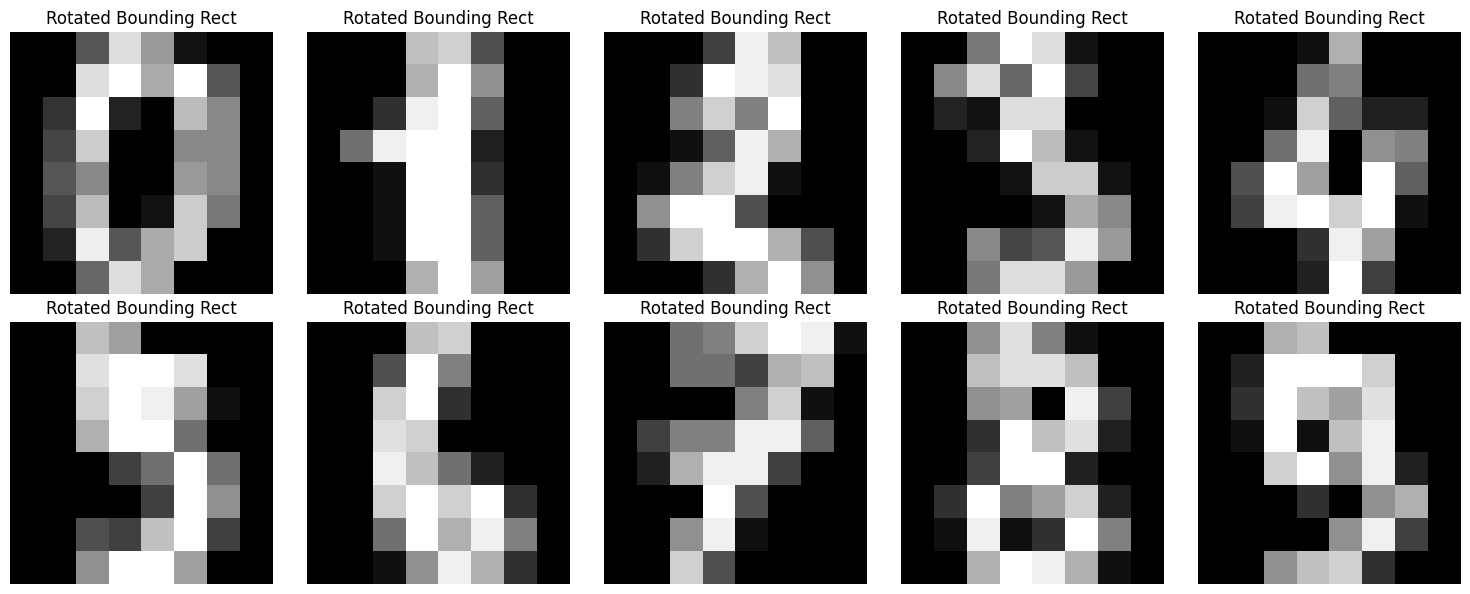

In [ ]:
# Combine rotated bounding rectangles info for digits 0 to 9
rotated_bounding_info_0_to_9 = ["Rotated Bounding Rect" for _ in rotated_bounding_rectangles[:10]]

# Plot rotated bounding rectangles for digits 0 to 9
plot_images_with_bounding_rectangles(digits.images[:10], rotated_bounding_info_0_to_9, num_images_per_row=5)


# Plot Minimum Enclosing Circles

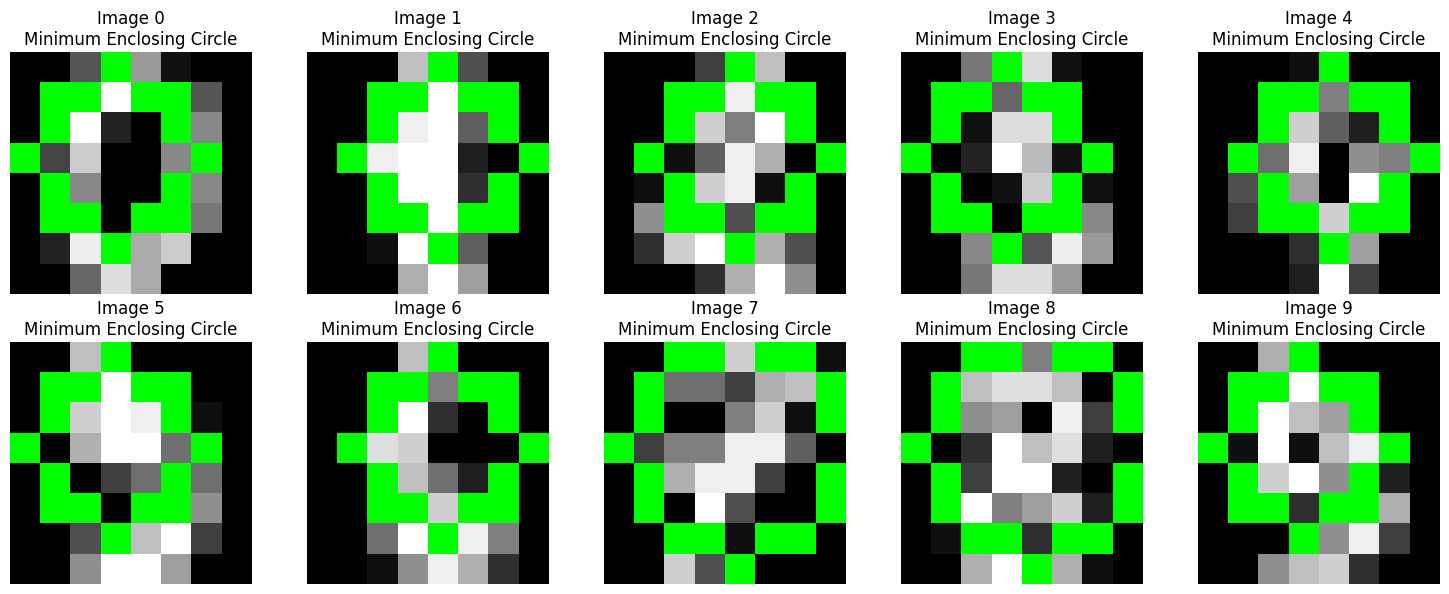

In [ ]:
def plot_images_with_circles(images, circle_centers_radii, num_images_per_row=5):
    num_images = len(images)
    num_rows = (num_images - 1) // num_images_per_row + 1

    fig, axs = plt.subplots(num_rows, num_images_per_row, figsize=(15, num_rows * 3))

    for i, (img, (center, radius)) in enumerate(zip(images, circle_centers_radii)):
        row = i // num_images_per_row
        col = i % num_images_per_row
        ax = axs[row, col]

        # Create a copy of the original image
        img_with_circle = np.array(img, copy=True)

        # Convert to suitable type for color conversion (uint8)
        img_with_circle = cv2.normalize(img_with_circle, None, 0, 255, cv2.NORM_MINMAX)
        img_with_circle = np.uint8(img_with_circle)

        # Convert to RGB for color visualization
        img_with_circle = cv2.cvtColor(img_with_circle, cv2.COLOR_GRAY2RGB)

        # Draw the minimum enclosing circle on the copied image
        cv2.circle(img_with_circle, center, radius, (0, 255, 0), 1)

        ax.imshow(img_with_circle)
        ax.set_title(f"Image {i}\nMinimum Enclosing Circle")
        ax.axis('off')

    for j in range(num_images, num_rows * num_images_per_row):
        row = j // num_images_per_row
        col = j % num_images_per_row
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Combine minimum enclosing circles centers and radii for digits 0 to 9
minimum_enclosing_info_0_to_9 = [(center, radius) for center, radius in minimum_enclosing_circles[:10]]

# Plot minimum enclosing circles overlaid on the original images for digits 0 to 9
plot_images_with_circles(digits.images[:10], minimum_enclosing_info_0_to_9, num_images_per_row=5)

# Fitting an Ellipse

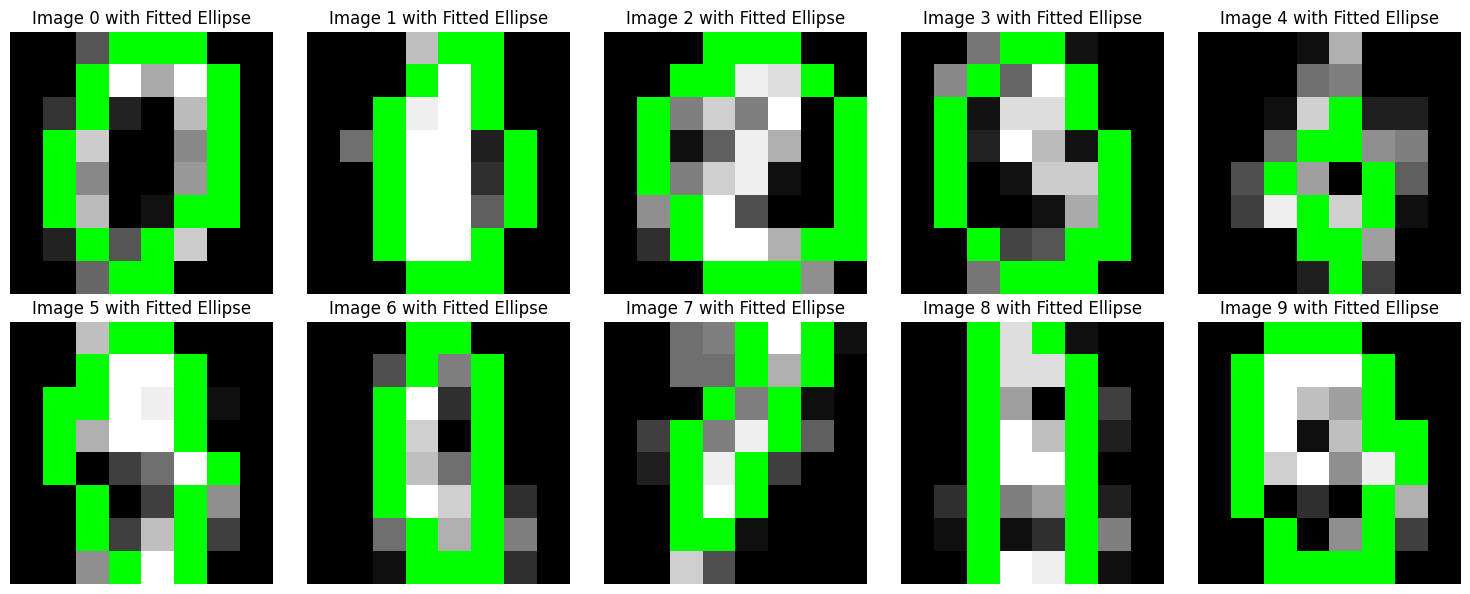

In [ ]:
def plot_images_with_ellipses(images, num_images_per_row=5):
    num_images = len(images)
    num_rows = (num_images - 1) // num_images_per_row + 1

    fig, axs = plt.subplots(num_rows, num_images_per_row, figsize=(15, num_rows * 3))

    for i, img in enumerate(images):
        row = i // num_images_per_row
        col = i % num_images_per_row
        ax = axs[row, col]

        # Convert the image to suitable format
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Threshold the image to get a binary image
        _, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

        # Find contours in the binary image
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create a copy of the original image
        img_with_ellipse = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        # Fit an ellipse if the contour has enough points
        if len(contours) > 0:
            contour = contours[0]
            if len(contour) >= 5:
                ellipse = cv2.fitEllipse(contour)
                cv2.ellipse(img_with_ellipse, ellipse, (0, 255, 0), 1)  # Green color

        ax.imshow(img_with_ellipse)
        ax.set_title(f"Image {i} with Fitted Ellipse")
        ax.axis('off')

    for j in range(num_images, num_rows * num_images_per_row):
        row = j // num_images_per_row
        col = j % num_images_per_row
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Plot images with fitted ellipses overlaid for all 10 digits
plot_images_with_ellipses(digits.images[:10], num_images_per_row=5)

# Fitting a Line

<ipython-input-10-af728fee54d1>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lefty = int((-x * vy / vx) + y)
<ipython-input-10-af728fee54d1>:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  righty = int(((cols - x) * vy / vx) + y)


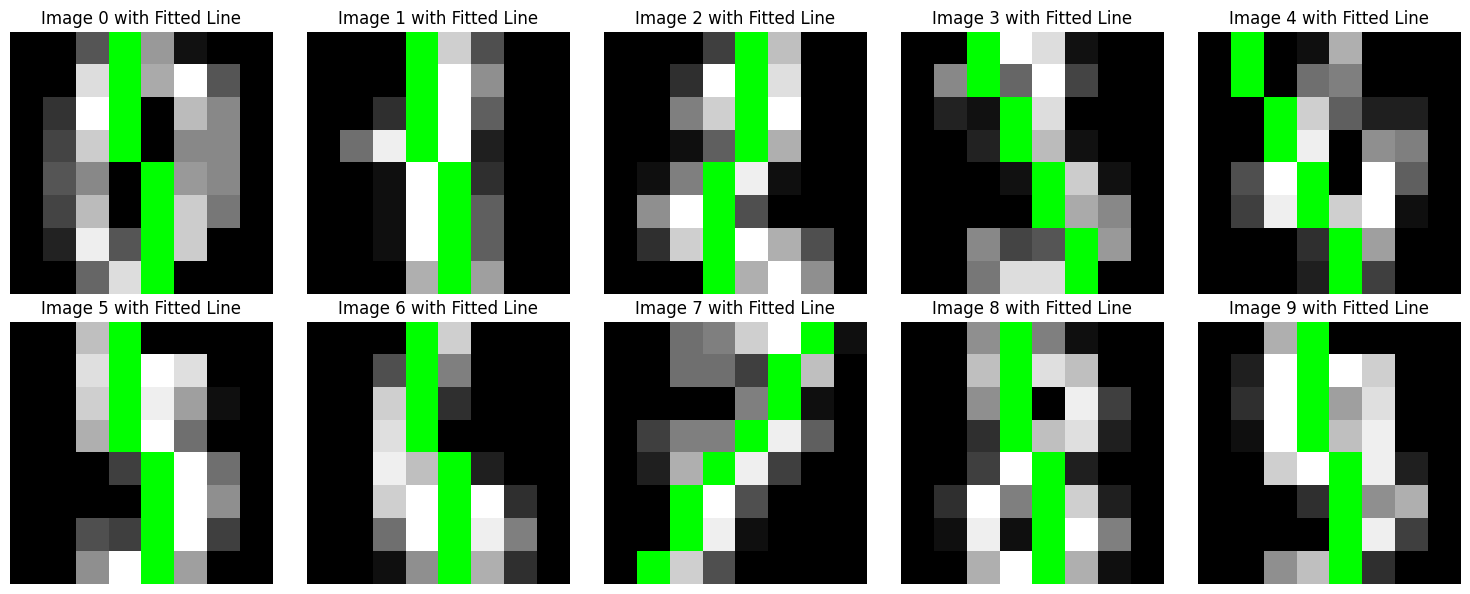

In [ ]:
def plot_images_with_lines(images, num_images_per_row=5):
    num_images = len(images)
    num_rows = (num_images - 1) // num_images_per_row + 1

    fig, axs = plt.subplots(num_rows, num_images_per_row, figsize=(15, num_rows * 3))

    for i, img in enumerate(images):
        row = i // num_images_per_row
        col = i % num_images_per_row
        ax = axs[row, col]

        # Convert the image to suitable format
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Threshold the image to get a binary image
        _, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

        # Find contours in the binary image
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create a copy of the original image
        img_with_lines = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        # Fit a line if the contour has enough points
        if len(contours) > 0:
            contour = contours[0]
            if len(contour) >= 2:
                # Fit a line to the contour
                rows, cols = img.shape[:2]
                [vx, vy, x, y] = cv2.fitLine(contour, cv2.DIST_L2, 0, 0.01, 0.01)
                lefty = int((-x * vy / vx) + y)
                righty = int(((cols - x) * vy / vx) + y)
                cv2.line(img_with_lines, (cols - 1, righty), (0, lefty), (0, 255, 0), 1)  # Green line

        ax.imshow(img_with_lines)
        ax.set_title(f"Image {i} with Fitted Line")
        ax.axis('off')

    for j in range(num_images, num_rows * num_images_per_row):
        row = j // num_images_per_row
        col = j % num_images_per_row
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Plot images with fitted lines overlaid for all 10 digits
plot_images_with_lines(digits.images[:10], num_images_per_row=5)